#Data Preparation

**Read data into dataframe news**

In [103]:
%pylab inline
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from pprint import pprint
from xgboost import XGBClassifier
from gensim.models import Phrases, LdaModel
from gensim.corpora import Dictionary
import nltk
nltk.download('stopwords')
nltk.download("wordnet")
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import brown
from nltk import FreqDist
from wordcloud import WordCloud 
from collections import OrderedDict

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\man28\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['title', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\man28\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\man28\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\man28\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [104]:
data_folder = "./bbc/"
folders = ["business","entertainment","politics","sport","tech"]

In [105]:
os.listdir(data_folder)

['business', 'entertainment', 'politics', 'README.TXT', 'sport', 'tech']

In [106]:
files = os.listdir('./bbc/business/')

In [107]:
folderslist = [f for f in os.listdir(data_folder) if '.' not in f]

In [108]:
folderslist

['business', 'entertainment', 'politics', 'sport', 'tech']

In [109]:
content = []
category = []

In [110]:
for folder in folders:
    folder_path = './bbc/'+folder+'/'
    files = os.listdir(folder_path)
    for text_file in files:
        file_path = folder_path + "/" +text_file
        with open(file_path, errors='replace') as f:
            # data = f.readlines()
            text_data = f.read().split('\n')
            text_data = list(filter(None, text_data))
        # data = ' '.join(data)      

        content.append(text_data)
        category.append(folder)

In [111]:
len(category)

2225

In [112]:
datadict = {'content':content, 'category':category}

In [113]:
df = pd.DataFrame(datadict)
df['content'] = df.content.astype(str)

In [114]:
df.describe()

,content,category
count,2225,2225
unique,2127,5
top,"['Ray DVD beats box office takings', 'Oscar-no...",sport
freq,2,511


In [115]:
df.head()

,content,category
0,"['Ad sales boost Time Warner profit', 'Quarter...",business
1,"['Dollar gains on Greenspan speech', 'The doll...",business
2,"['Yukos unit buyer faces loan claim', 'The own...",business
3,"[""High fuel prices hit BA's profits"", 'British...",business
4,"['Pernod takeover talk lifts Domecq', ""Shares ...",business


In [116]:
df.content[1][:1000]

'[\'Dollar gains on Greenspan speech\', \'The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.\', \'And Alan Greenspan highlighted the US government\\\'s willingness to curb spending and rising household savings as factors which may help to reduce it. In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday. Market concerns about the deficit has hit the greenback in recent months. On Friday, Federal Reserve chairman Mr Greenspan\\\'s speech in London ahead of the meeting of G7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worse-than-expected US jobs data. "I think the chairman\\\'s taking a much more sanguine view on the current account deficit than he\\\'s taken for some time," said Robert Sinche, head of currency strategy at Bank of America in New York. "He\\\'s taking a longer-term view, laying out a se

In [117]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

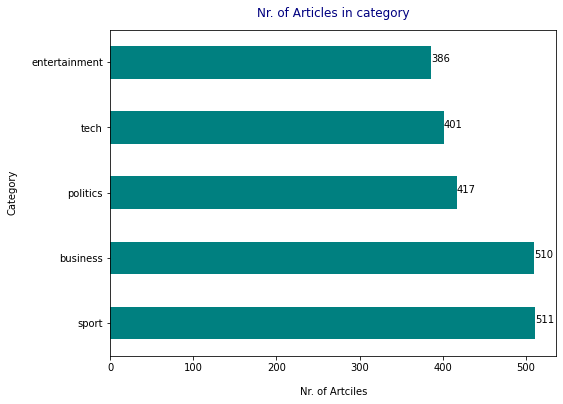

In [118]:
bar_plot = df.category.value_counts().plot(kind='barh', figsize=(8, 6), color='teal')
plt.xlabel("Nr. of Artciles", labelpad=14)
plt.ylabel("Category", labelpad=14)
plt.title("Nr. of Articles in category", y=1.02, color='navy')

for index, value in enumerate(df.category.value_counts()):
    plt.text(value, index, str(value))

**Label Encoder**

In [119]:
# 0 - business, 1 - entertainment, 2 - politics, 3 - sport, 4 - tech
label_enc = LabelEncoder()
df['label'] = label_enc.fit_transform(df['category'])
df.tail()

,content,category,label
2220,"['BT program to beat dialler scams', 'BT is in...",tech,4
2221,"['Spam e-mails tempt net shoppers', 'Computer ...",tech,4
2222,"['Be careful how you code', 'A new European di...",tech,4
2223,"['US cyber security chief resigns', 'The man m...",tech,4
2224,"['Losing yourself in online gaming', 'Online r...",tech,4


In [120]:
# An array of words
df_txt = np.array(df['content'])

In [121]:
df_txt

array(['[\'Ad sales boost Time Warner profit\', \'Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.\', \'The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\', "Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and

**Pre-process and vectorize text**

In [122]:
stopwords = nltk.corpus.stopwords.words('english')

def docs_preprocessor(docs):
    # Remain only letters
    tokenizer = RegexpTokenizer('[A-Za-z]\w+')
    
    for idx in range(len(docs)):
        # Convert to lowercase
        docs[idx] = docs[idx].lower() 
        # Split into words
        docs[idx] = tokenizer.tokenize(docs[idx])  
    
    # Lemmatize all words with len>2 in documents 
    lemmatizer = WordNetLemmatizer()
    docs = [[nltk.stem.WordNetLemmatizer().lemmatize(token) for token in doc if len(token) > 2 and token not in stopwords] for doc in docs]
    #stemmer = SnowballStemmer('english')
    #docs = [[stemmer.stem(token) for token in doc if len(token) > 2 and token not in stopwords] for doc in docs]
         
    return docs

In [123]:
df_txt = docs_preprocessor(df_txt)

In [124]:
# Add bigrams and trigrams to docs (only ones that appear 10 times or more)
bigram = Phrases(df_txt, min_count=10)
trigram = Phrases(bigram[df_txt])

for idx in range(len(df_txt)):
    for token in bigram[df_txt[idx]]:
        if '_' in token:
            df_txt[idx].append(token)
    for token in trigram[df_txt[idx]]:
        if '_' in token:
            df_txt[idx].append(token)

**Remove rare words**

In [125]:
# Create a dictionary representation of the documents
dictionary = Dictionary(df_txt)
print('Nr. of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 20% of the documents
dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Nr. of unique words after removing rare and common words:', len(dictionary))

Nr. of unique words in initital documents: 27417
Nr. of unique words after removing rare and common words: 5865


In [126]:
df['text2'] = df_txt

In [127]:
df['text3'] = [' '.join(map(str, j)) for j in df['text2']]

In [128]:
df.iloc[1475:1480,:]

,content,category,label,text2,text3
1475,"['Arsenal through on penalties', 'Arsenal win ...",sport,3,"[arsenal, penalty, arsenal, win, penalty, span...",arsenal penalty arsenal win penalty spanish go...
1476,"['Ajax refuse to rule out Jol move', ""Ajax hav...",sport,3,"[ajax, refuse, rule, jol, move, ajax, refused,...",ajax refuse rule jol move ajax refused reveal ...
1477,"['Unclear future for striker Baros', ""Liverpoo...",sport,3,"[unclear, future, striker, baros, liverpool, f...",unclear future striker baros liverpool forward...
1478,"['Prutton poised for lengthy FA ban', ""Southam...",sport,3,"[prutton, poised, lengthy, ban, southampton, d...",prutton poised lengthy ban southampton david p...
1479,"['Robben plays down European return', 'Injured...",sport,3,"[robben, play, european, return, injured, chel...",robben play european return injured chelsea wi...


**Word Vectors**

In [129]:
vectorizer = TfidfVectorizer(input='content', analyzer = 'word', lowercase=True, stop_words='english',\
                                   ngram_range=(1, 3), min_df=40, max_df=0.20,\
                                  norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)
text_vector = vectorizer.fit_transform(df.text3)
dtm = text_vector.toarray()
features = vectorizer.get_feature_names()

C:\Users\man28\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [130]:
h = pd.DataFrame(data = text_vector.todense(), columns = vectorizer.get_feature_names())
h.iloc[990:1000,280:300]

,clearly,client,clive,close,closed,closely,closer,club,coach,code,colleague,collection,comedy,coming,comment,commercial,commission,commitment,committed,committee
990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.161645,0.0
994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.059623,0.000000,0.0,0.0,0.0,0.000000,0.0
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.066520,0.0,0.0,0.0,0.000000,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077288,0.0,0.0,0.000000,0.059858,0.0,0.0,0.0,0.000000,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.067769,0.000000,0.0,0.0,0.0,0.000000,0.0


In [131]:
corpus = [dictionary.doc2bow(txt) for txt in df_txt]

In [132]:
print(f'Number of unique tokens: {len(dictionary)}')
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 5865
Number of documents: 2225


#Clustering using Latent Dirichlet Allocation (LDA)

In [133]:
# Set training parameters
num_topics = 5
chunksize = 500 # Number of documents to consider at once (affects the memory consumption)
passes = 20 # Number of passes through documents
iterations = 20000
eval_every = 1  

# Make a index to word dictionary
temp = dictionary[0] 
id2word = dictionary.id2token

model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', random_state=78, \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [134]:
# Frequency of top words in each topic
def explore_topic(lda_model, topic_number, topn, output=True):
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))   
    return terms

topic_summaries = []

print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+'\n')
    tmp = explore_topic(model,topic_number=i, topn=10, output=True)
    topic_summaries += [tmp[:5]]
    print('\n')

term                 frequency

Topic 0

year_old             0.014
film                 0.011
best                 0.010
last_year            0.007
award                0.007
star                 0.005
win                  0.005
old                  0.005
final                0.005
show                 0.004


Topic 1

game                 0.031
player               0.010
play                 0.008
england              0.008
six_nation           0.006
half                 0.005
playing              0.005
side                 0.005
team                 0.005
video_game           0.005


Topic 2

prime_minister       0.007
labour               0.006
party                0.006
election             0.006
minister             0.006
blair                0.005
law                  0.004
plan                 0.004
tory                 0.004
tony_blair           0.004


Topic 3

mobile               0.010
technology           0.009
phone                0.009
service              0.008
mobile_p

In [135]:
# Assign a human-interpretable 
top_labels = {0: 'business', 1:'sport', 2:'tech', 3:'entertainment', 4:'politics'}

In [136]:
top_dist =[]
for d in corpus:
    tmp = {i:0 for i in range(num_topics)}
    tmp.update(dict(model[d]))
    vals = list(OrderedDict(tmp).values())
    top_dist += [array(vals)]

def get_doc_topic_dist(model, corpus, kwords=False):
    '''
    LDA transformation, for each doc only returns topics with non-zero weight
    This function makes a matrix transformation of docs in the topic space.
    
    model: the LDA model
    corpus: the documents
    kwords: if True adds and returns the keys
    '''
    top_dist =[]
    keys = []

    for d in corpus:
        tmp = {i:0 for i in range(num_topics)}
        tmp.update(dict(model[d]))
        vals = list(OrderedDict(tmp).values())
        top_dist += [array(vals)]
        if kwords:
            keys += [array(vals).argmax()]

    return array(top_dist), keys

top_dist, lda_keys= get_doc_topic_dist(model, corpus, True)

In [137]:
top_ws = []
for n in range(len(dtm)):
    inds = int0(argsort(dtm[n])[::-1][:4])
    tmp = [features[i] for i in inds]
    
    top_ws += [' '.join(tmp)]
    
df['Text_Rep'] = pd.DataFrame(top_ws)
df['clusters'] = pd.DataFrame(lda_keys)
df['clusters'].fillna(10, inplace=True)

cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 3: 'red', 4: 'skyblue'}

df['colors'] = df['clusters'].apply(lambda j: cluster_colors[j])
# Assign a human-interpretable labels 
df['category_lda'] = df['clusters'].replace([0, 1, 2, 3, 4],['business','sport','tech','entertainment','politics'])

#Clusters visualization

In [138]:
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource

ModuleNotFoundError: No module named 'bokeh'

In [ ]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(top_dist)

df['X_tsne'] =X_tsne[:, 0]
df['Y_tsne'] =X_tsne[:, 1]

output_notebook()

source = ColumnDataSource(dict(
    x=df['X_tsne'],
    y=df['Y_tsne'],
    color=df['colors'],
    label=df['clusters'].apply(lambda l: top_labels[l]),
    topic_key= df['clusters'],
    # title= df[u'title'],
    content = df['text3'],
    legend_field=df['category_lda']
))

df = df.drop(columns=['colors','Text_Rep','X_tsne','Y_tsne'])

In [ ]:
title = 'Topics visualization'

plot_lda = figure(plot_width=1000, plot_height=600,
                     title=title, 
                     x_axis_type=None, y_axis_type=None, min_border=1)
plot_lda.scatter(x='x', y='y', legend_field='legend_field',  source=source,
                 color='color', alpha=0.6, size=5.0)

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "Title: @title, KeyWords: @content - Topic: @topic_key "}
plot_lda.legend.location = "top_left"

show(plot_lda)

In [ ]:
for x in df.category.unique():
    wc = WordCloud(width = 800, height = 800, background_color ='white', stopwords=stopwords,
                   min_font_size = 10, random_state=42)
    wc.generate(df.text3[(df.category == x)].to_string())
    
    plt.imshow(wc)
    plt.tight_layout(pad = 0) 
    plt.title(x)
    plt.axis("off")
    plt.show()